# Importing Necessary Packages

In [2]:
import pandas as pd
import datetime as dt
pd.set_option('display.max_rows', 500)

import seaborn as sns
import folium as fm 
import matplotlib.pyplot as plt
from haversine import haversine as hs
import operator as op
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 200)

plt.rcParams['figure.figsize'] = (25, 14)
plt.style.use('seaborn-whitegrid')




<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Creating a Function to Process XLS File

In [5]:
def xls_to_df(file, sheet_num):
    sheet = pd.read_excel(fr"C:\Users\faela\OneDrive\Desktop\CCT Masters\CA_1\counts_2018\Client Site {file}.xlsx", sheet_name = sheet_num)
    #import xls and choose sheet
    sheet.drop(sheet.head(7).index, inplace=True)
    new_names = ['Time', 'P/C', 'M/C', 'Car', 'LGV', 'HGV 2x', 'HGV 3x', 'HGV 4x', 'HGV 5x', 'Dbus', 'Obus', 'Taxi', 'Ped', 'Total Veh', 'PCU', 'Time_1','P/C_1', 'M/C_1', 'Car_1', 'LGV_1', 'HGV 2x_1', 'HGV 3x_1', 'HGV 4x_1', 'HGV 5x_1', 'Dbus_1', 'Obus_1', 'Taxi_1', 'Ped_1', 'Total Veh_1', 'PCU_1', 'Junction Total', 'Hourly Total', 'Time_2' ]

    try:
        #try change column names
        sheet.columns = new_names
    except:
        if sheet_num == 0:
            sheet = pd.read_excel(fr"C:\Users\faela\OneDrive\Desktop\CCT Masters\CA_1\counts_2018\Client Site {file}.xlsx", sheet_name = 1)  
        elif sheet_num == 2:
            sheet = pd.read_excel(fr"C:\Users\faela\OneDrive\Desktop\CCT Masters\CA_1\counts_2018\Client Site {file}.xlsx", sheet_name = 6)  
            
        sheet.drop(sheet.head(7).index, inplace=True)
        #change column names
        sheet.columns = new_names
            
    
    #change column names
    # Drop last 3 columns of dataframe as not needed
    sheet = sheet.iloc[: , :-3]
    sheet = sheet[ (sheet['Time'] != 'Hour') & (sheet['Time'] != '3 Hour') & (sheet['Time'] != 'Total')]
    sheet.reset_index(drop = True, inplace = True)

    #After changes we need to fix data types
    sheet = sheet.infer_objects()

    #finally convert time

    sheet['Time'] = pd.to_datetime(sheet['Time_1'], format='%H:%M:%S').dt.time
    sheet['Time_1'] = pd.to_datetime(sheet['Time_1'], format='%H:%M:%S').dt.time
        
    #finally return the sheet
    return sheet

# 2018 Cordon Count Data

In [6]:
#Import all the xls files and generate dataframes for each file&sheet
df_2018 = {}
for i in [0,2]:
    for j in range(33):
        #Assign dataframes using dictionary
        df_2018[f"site_day_{j+1}_{i}"] = xls_to_df(j+1,i)
           

Lets look at the total number of counts in each catagory over the whole network given the 2 day period. These will be broken into inbound & outbound directions of travel

In [7]:
def total_count(df):
    counts_1 = []
    counts_2 = []
    for j in range(33):
        #finding the number of pedestrians that pass the counter each day during 7-10am
        day_am_1 = df[f'site_day_{j+1}_0'][(df[f'site_day_{j+1}_0']['Time'] >= dt.time(7)) & (df[f'site_day_{j+1}_0']['Time'] < dt.time(10))]
        day_am_2 = df[f'site_day_{j+1}_2'][(df[f'site_day_{j+1}_2']['Time'] >= dt.time(7)) & (df[f'site_day_{j+1}_2']['Time'] < dt.time(10))]
        #getting sum and adding to empty container
        counts_1.append(day_am_1.sum())
        counts_2.append(day_am_2.sum())
        #getting the avg of both to find the number of per day counts
    avg_counts = [(sum(x)/2) for x in zip(counts_1, counts_2)]
    return sum(avg_counts)
    

In [8]:
Totals = total_count(df_2018)

In [9]:
inbound = Totals[:12]#filtering out only inbound data
inbound

P/C       12227.0
M/C        1477.0
Car       43558.0
LGV        5262.0
HGV 2x      811.5
HGV 3x      108.5
HGV 4x      144.5
HGV 5x       88.5
Dbus       1267.0
Obus        570.0
Taxi       4398.5
Ped       23857.5
dtype: float64

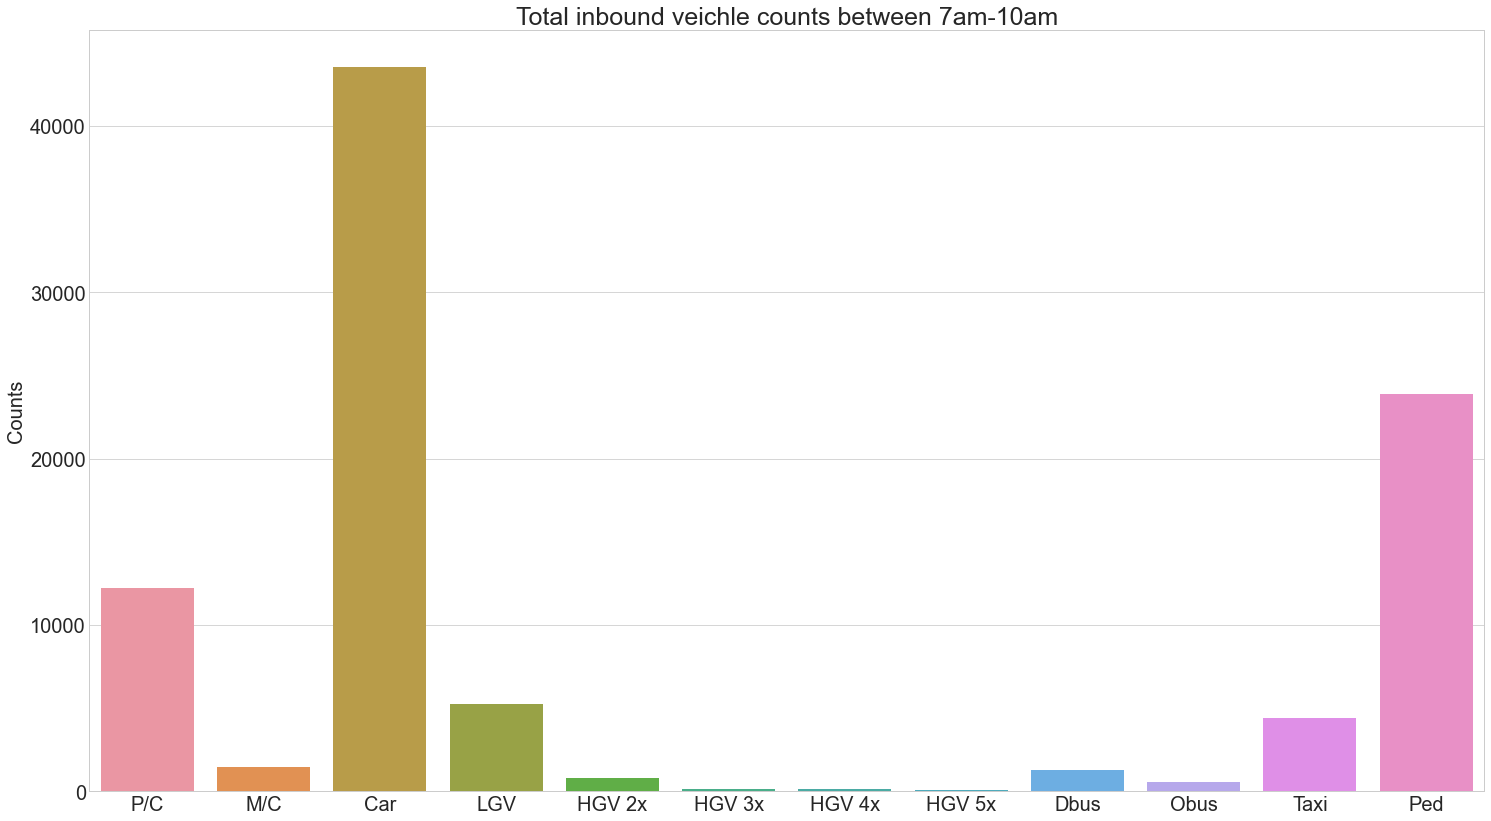

In [10]:
#creating barplot and customising features
fig = sns.barplot(x = inbound.index.values, y = inbound)
fig.tick_params(labelsize = 20)

fig.axes.set_title('Total inbound veichle counts between 7am-10am', fontsize = 25)
plt.ylabel('Counts', fontsize = 20)
plt.savefig('inbound_total.png')
plt.show()

Precentage of travelers inbound/outbound that are on foot and bicycle

In [11]:
#pedestrian
ped = inbound['Ped']/inbound.sum()
print(f'{ped*100}% of inbound travelers are on foot')

25.442572251253065% of inbound travelers are on foot


In [12]:
P_C = inbound['P/C']/inbound.sum()
print(f'{P_C*100}% of inbound travelers are on bicycles')

13.039351604990934% of inbound travelers are on bicycles


# Lets drill down on the pedestrian and cyclist counts specifically. Only inbound

### We want to plot pedestrian and cyclist counts against location forst and identify the top locations for each we will take the average inbound over 2 days at each location

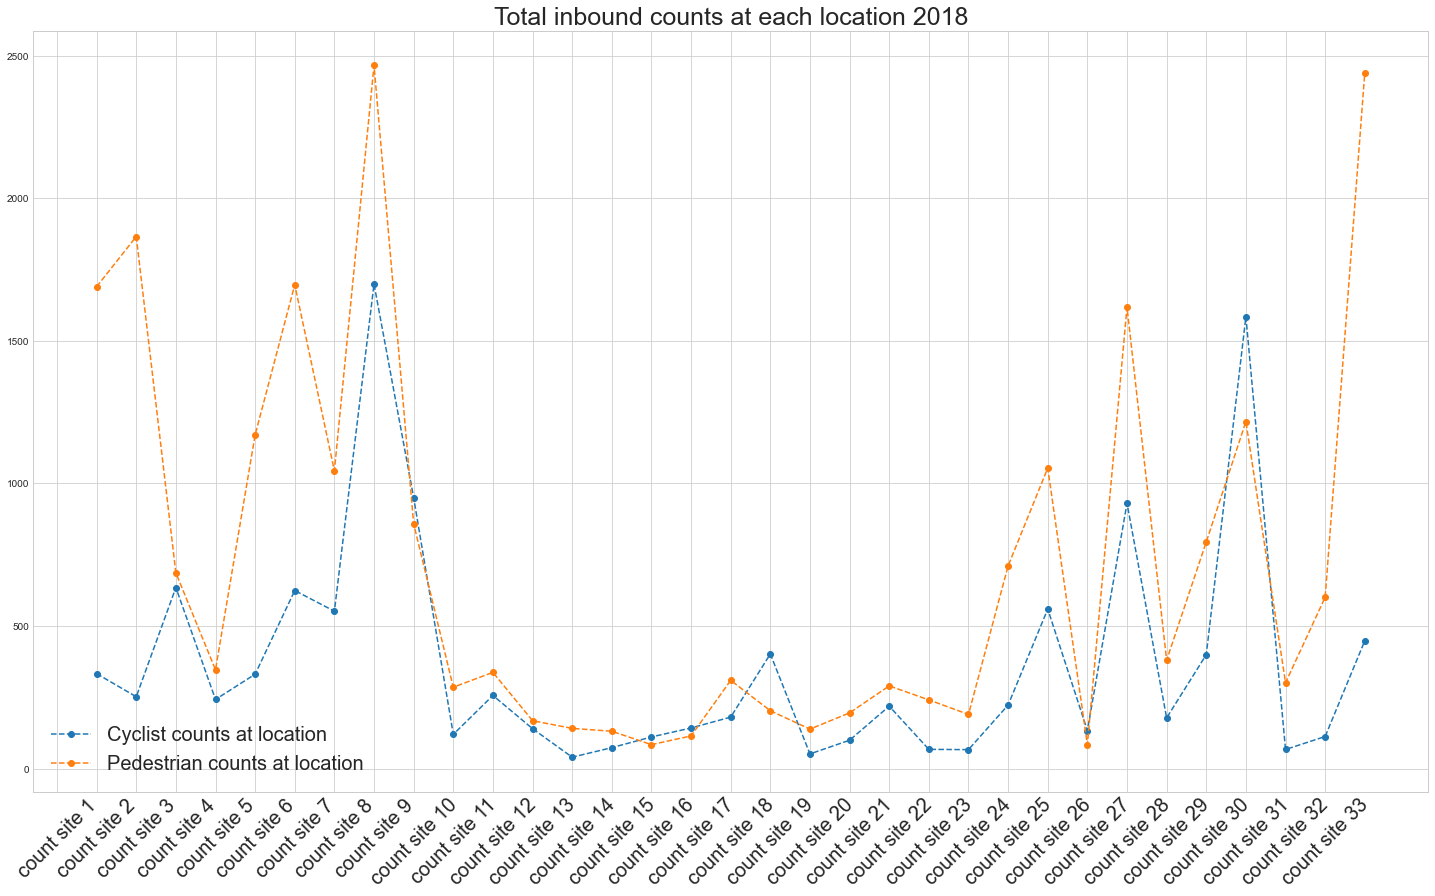

In [13]:
def count_am_pct(field, df, n):
    counts_1 = []
    counts_2 = []
    tot_1 = []
    tot_2 = []
    for j in range(33):
        #finding the total number of pedestrians that pass the counter each day
        day_am_1 = df[f'site_day_{j+1}_0'][(df[f'site_day_{j+1}_0']['Time'] >= dt.time(7)) & (df[f'site_day_{j+1}_0']['Time'] < dt.time(10))]
        day_am_2 = df[f'site_day_{j+1}_2'][(df[f'site_day_{j+1}_2']['Time'] >= dt.time(7)) & (df[f'site_day_{j+1}_2']['Time'] < dt.time(10))]
        #appending to empty list
        counts_1.append(day_am_1[field].sum())
        counts_2.append(day_am_2[field].sum())
        #getting the avg of both to find the number of per day counts
    avg_counts = [(sum(x)/2) for x in zip(counts_1, counts_2)]
    total_count = sum(avg_counts)
    #this part lets us specify the function output based on the value of n 0 is avg counts, 1 is pct of counts
    if n == 0:
        return avg_counts
    else:
        return (avg_counts/sum(avg_counts))*100
        
#we need this for the ticks on x axis
locations = [f'count site {i+1}' for i in range(33)]

plt.plot(locations, count_am_pct('P/C', df_2018, 0),  'o--', label = 'Cyclist counts at location') 
plt.plot(locations, count_am_pct('Ped', df_2018, 0),  'o--', label = 'Pedestrian counts at location') 
plt.legend(fontsize = 20)
plt.title('Total inbound counts at each location 2018', fontsize = 25)
#formatting x axis ticks
x = range(-1,32,1)
plt.xticks(x, locations,rotation = 45, fontsize = 20)
plt.show()

    

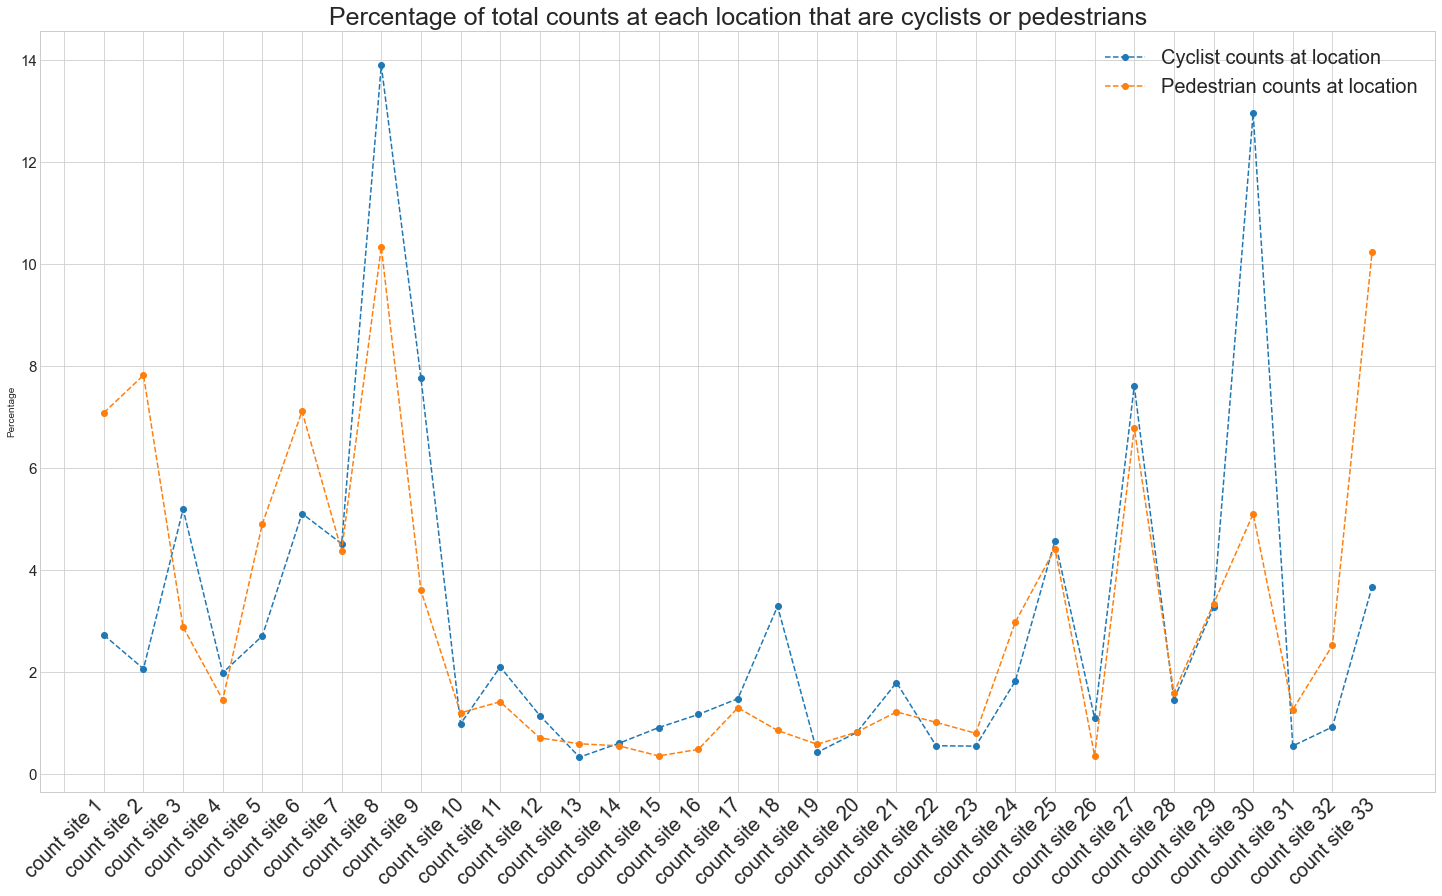

In [14]:
plt.plot(locations, count_am_pct('P/C', df_2018, 1),  'o--', label = 'Cyclist counts at location') 
plt.plot(locations, count_am_pct('Ped', df_2018, 1),  'o--', label = 'Pedestrian counts at location') 
plt.legend(fontsize = 20)
plt.title('Percentage of total counts at each location that are cyclists or pedestrians', fontsize = 25)
plt.xticks(x, locations,rotation = 45, fontsize = 20)
plt.yticks(fontsize = 15)
plt.ylabel('Percentage')
plt.savefig('ped_pc_pct.png')
plt.show()
    

## Cycle stats

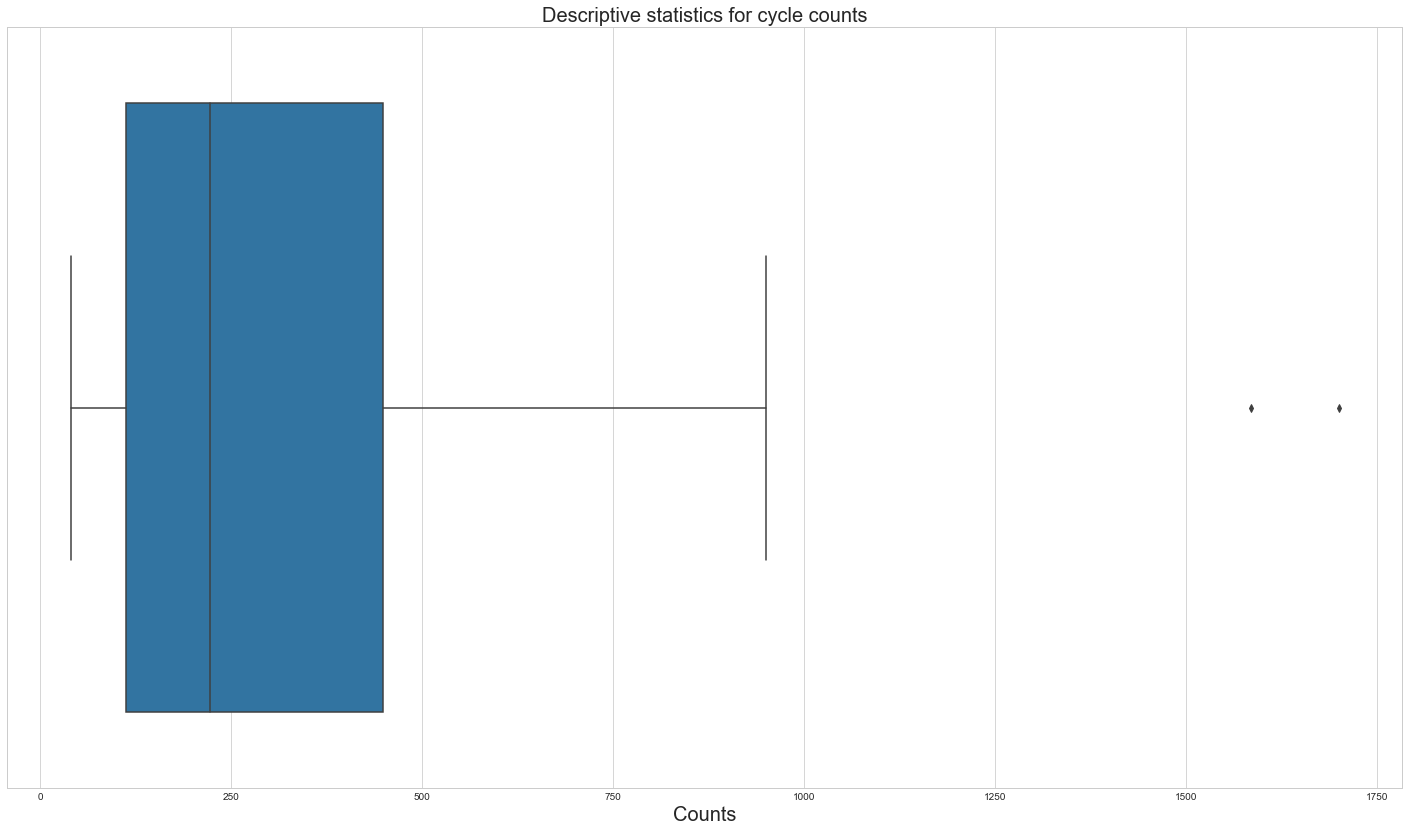

       Cycle Counts
count     33.000000
mean     370.515152
std      405.950957
min       40.000000
25%      112.500000
50%      223.000000
75%      448.500000
max     1699.500000
[1699.5, 1585.0]


In [15]:
cycle = pd.DataFrame(np.array(count_am_pct('P/C', df_2018, 0)), columns = ['Cycle Counts']) #importing cycle counts at each counter

#making boxplot
sns.boxplot(cycle['Cycle Counts'])
plt.xlabel('Counts', fontsize = 20)
plt.title('Descriptive statistics for cycle counts', fontsize = 20)
plt.savefig('cycle_boxplot.png')
plt.show()

#outlier calculations, fairly simple code i shouldnt need to explain
def outliers(x):
    q1 = np.quantile(x,0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3-q1
    outlier = []
    for i in x:
        if (q3 + iqr*1.5) < i:
            outlier.append(i)
            
        elif (q1 - iqr*1.5) > i:
            outlier.append(i)
            
    return outlier
#printing summary stats and outlier            
print(cycle.describe())
print(outliers(cycle['Cycle Counts']))

## Pedestrian stats

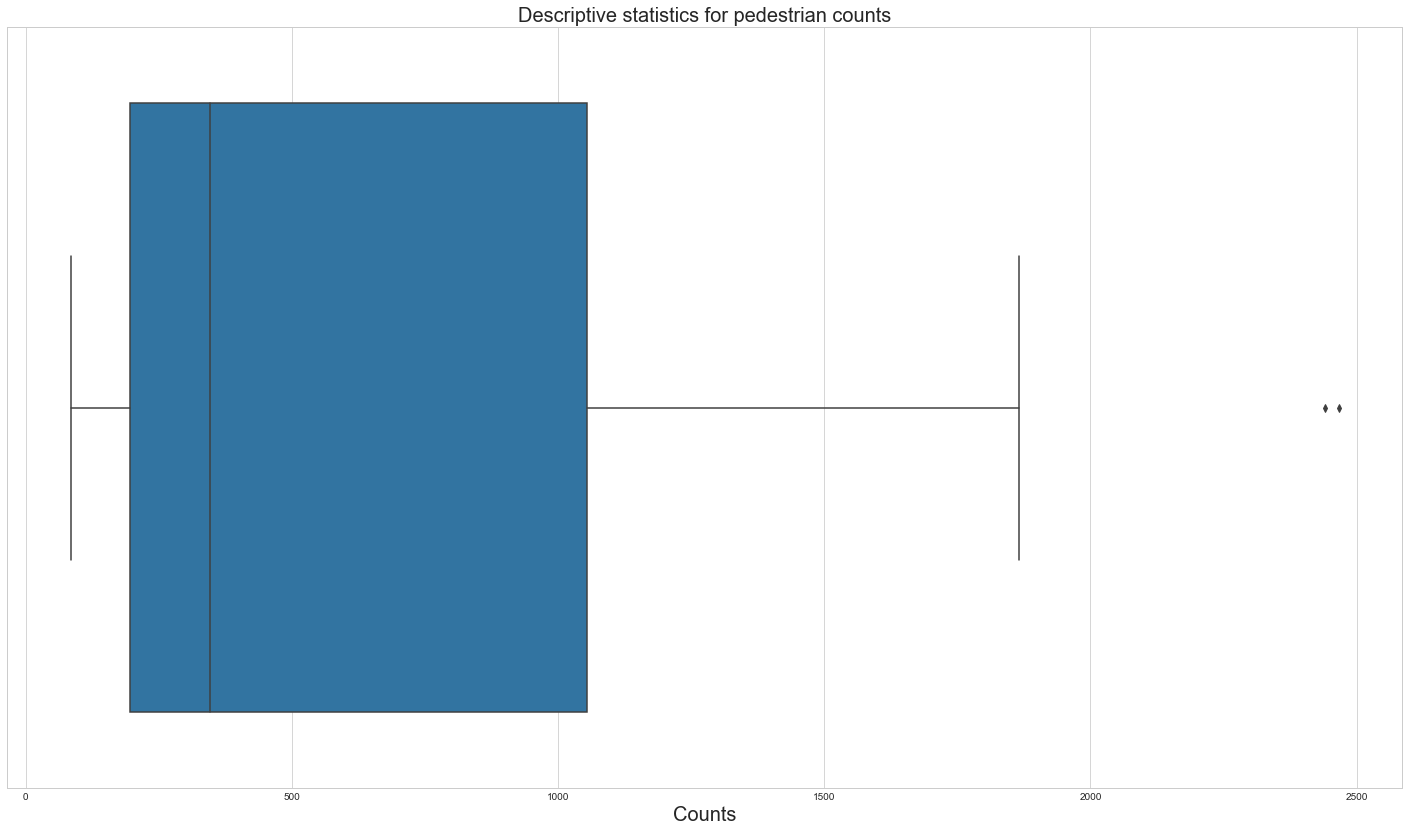

[2466.5, 2441.0]


,ped Counts
count,33.000000
mean,722.954545
std,693.888053
min,84.000000
25%,195.500000
50%,346.500000
75%,1054.000000
max,2466.500000


In [16]:
#assigning pedestrian totals at each station to df
ped = pd.DataFrame(np.array(count_am_pct('Ped', df_2018, 0)), columns = ['ped Counts'])

#making boxplot
sns.boxplot(ped['ped Counts'])
plt.xlabel('Counts', fontsize = 20)
plt.title('Descriptive statistics for pedestrian counts', fontsize = 20)
plt.savefig('ped_boxplot.png')
plt.show()

#printing outliers and summary stats
print(outliers(ped['ped Counts']))
ped.describe()


### making boxplots to compare the counts at eaxh location

# Poisson / normal

In [17]:
from scipy.stats import poisson as PS
from scipy.stats import norm
def poisson(field, df, n):
    prob_poisson = [] 
    prob_normal = []
    means = []
    site = []
    #for loop to find mean counts at each site, this will be our value of lambda
    for i in range(33):  
        site.append(i+1)
        day_am_1 = df[f'site_day_{i+1}_0'][(df[f'site_day_{i+1}_0']['Time'] >= dt.time(7)) & (df[f'site_day_{i+1}_0']['Time'] < dt.time(10))]
        day_am_2 = df[f'site_day_{i+1}_2'][(df[f'site_day_{i+1}_2']['Time'] >= dt.time(7)) & (df[f'site_day_{i+1}_2']['Time'] < dt.time(10))]
        mean = np.mean((day_am_1[field] + day_am_2[field])/2)*4 #times 4 to get hourly 
        means.append(mean)
        #poisson
        prob_poisson.append(PS.sf(k = n, mu = mean)) 
        
        #normal
        Z = ((n+0.5)-mean)/np.sqrt(mean)
        prob_normal.append(norm.sf(Z))
        
        
    df = pd.DataFrame(prob_poisson, columns = ['P(X>n) - Poisson'])
    df['P(X>n) - Normal'] = prob_normal
    df['Mean'] = means
    df['Delta'] = np.abs(df['P(X>n) - Normal'] - df['P(X>n) - Poisson']) 
    df['Location'] = site
    
    return df
    
    

## Now comparing gaussian and poisson graphically

In [18]:
probs = poisson('Ped', df_2018, 120)
probs.sort_values(by = ['Mean'], inplace = True, ignore_index = True)
probs


,P(X>n) - Poisson,P(X>n) - Normal,Mean,Delta,Location
0,1.414553e-38,1.002319e-68,28.000000,1.414553e-38,26
1,1.414553e-38,1.002319e-68,28.000000,1.414553e-38,15
2,1.154157e-26,8.058708e-41,38.166667,1.154157e-26,16
3,5.985837e-22,1.499078e-31,43.666667,5.985837e-22,14
4,4.274329e-20,3.707907e-28,46.166667,4.274329e-20,19
5,1.635950e-19,4.052703e-27,47.000000,1.635950e-19,13
6,3.685143e-14,3.371910e-18,56.000000,3.684805e-14,12
7,7.908409e-11,3.401319e-13,63.333333,7.874395e-11,23
8,4.118733e-10,3.578791e-12,65.166667,4.082945e-10,20
9,3.357958e-09,6.691968e-11,67.666667,3.291038e-09,18


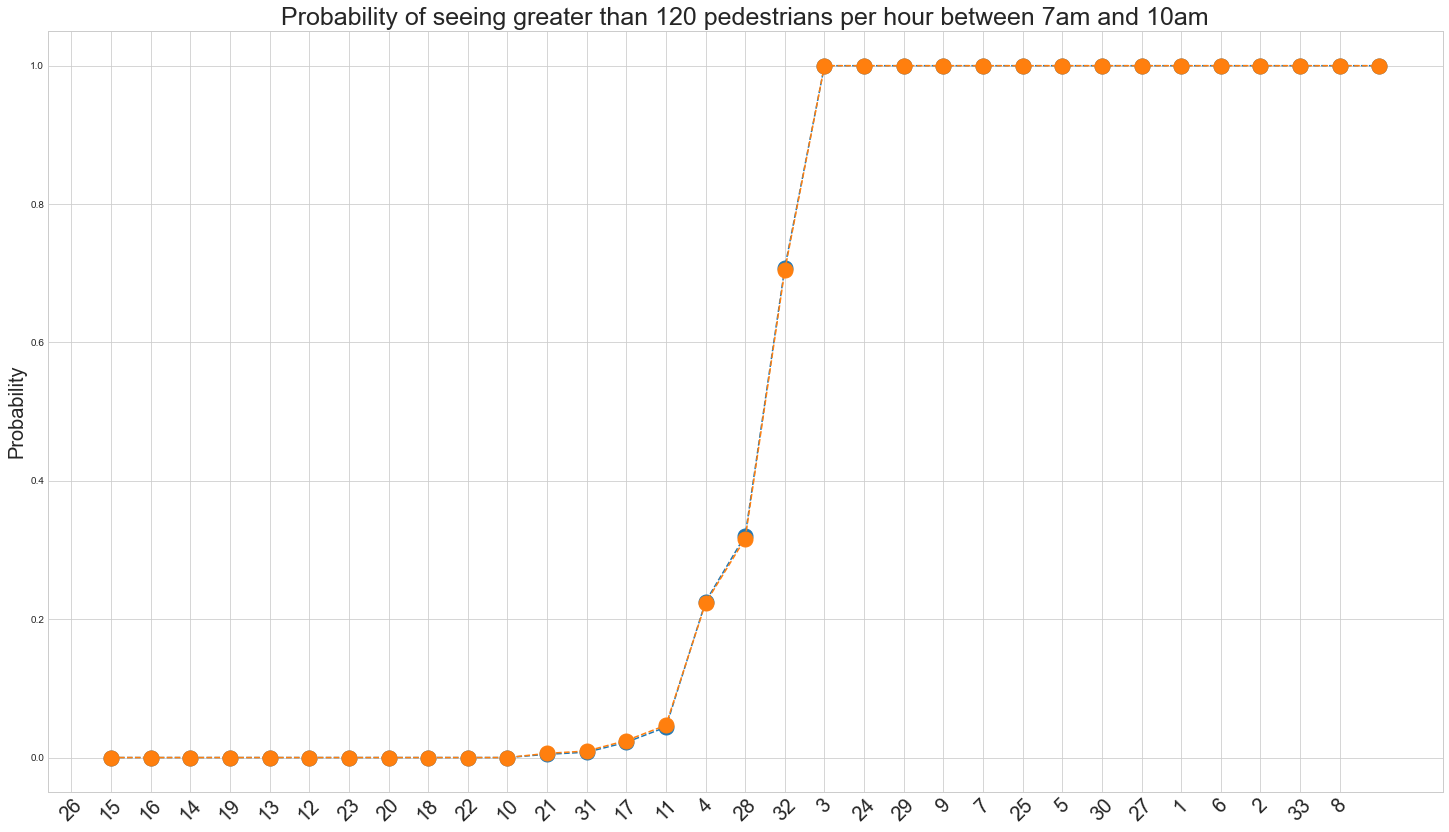

In [19]:
plt.plot(probs['P(X>n) - Normal'], 'o--', label='Normal pmf', markersize = 15) #plot poisson probs
plt.plot(probs['P(X>n) - Poisson'], 'o--', label='poisson pmf', markersize = 15)#plot normal probs
plt.xticks(np.arange(-1,32,1), labels = probs['Location'], rotation = 45, fontsize = 20)#sorting out tick markers
#final formatting
plt.title('Probability of seeing greater than 120 pedestrians per hour between 7am and 10am', fontsize = 25)
plt.ylabel('Probability', fontsize = 20)
plt.savefig('probs_plot.png')
plt.show()

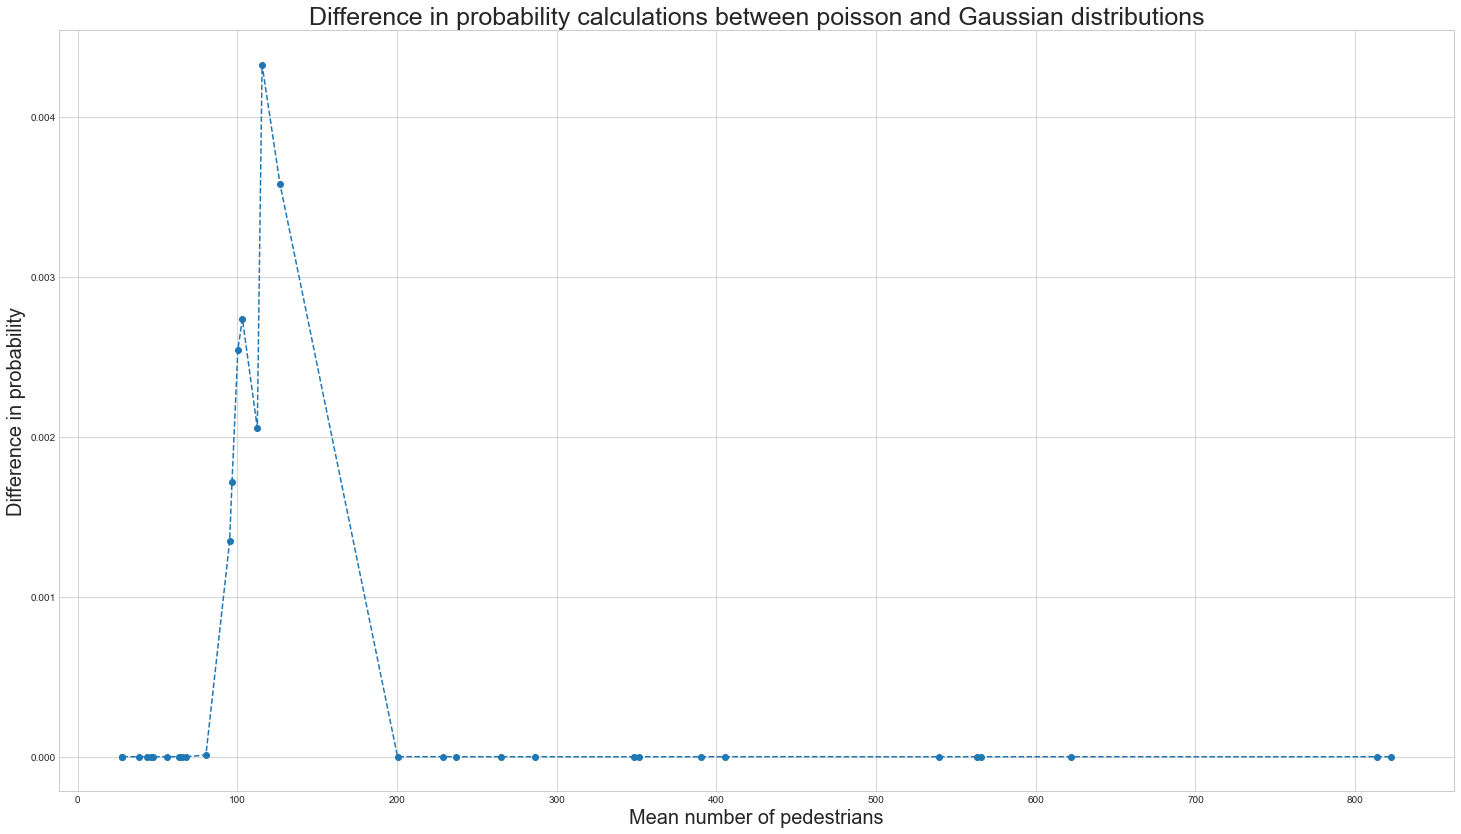

In [20]:
#looking at difference in prob values wrt lambda
probs.sort_values(by = ['Mean'], inplace = True, ignore_index = True)
plt.plot(probs['Mean'],probs['Delta'], 'o--')
plt.xlabel('Mean number of pedestrians', fontsize = 20)
plt.ylabel('Difference in probability', fontsize = 20)
plt.title('Difference in probability calculations between poisson and Gaussian distributions', fontsize = 25)
plt.savefig('probs_diff.png')
plt.show()